# Examples with MCMC

## First check the MCMC algorithms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQ_in_ML.mcmc_utils import *
from pyDOE import lhs

AM done, acceptance ratio of chain = 0.242


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


AM done, acceptance ratio of chain = 0.3541
DE-MC done, acceptance ratios of chains = 0.3688, 0.3629, 0.3566, 0.3615, 0.3624, 0.366, 0.3565, 0.3609, 0.3605, 0.3608
Rhat = 1.0003846524634032; if > 1.2, continue running the chain!
Rhat = 1.000348041750866; if > 1.2, continue running the chain!


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


DE-MC done, acceptance ratios of chains = 0.3544, 0.3479, 0.3503, 0.3503, 0.3449, 0.3457, 0.3481, 0.3542, 0.3494, 0.3484
Rhat = 1.0003246777494985; if > 1.2, continue running the chain!
Rhat = 1.000430200415754; if > 1.2, continue running the chain!


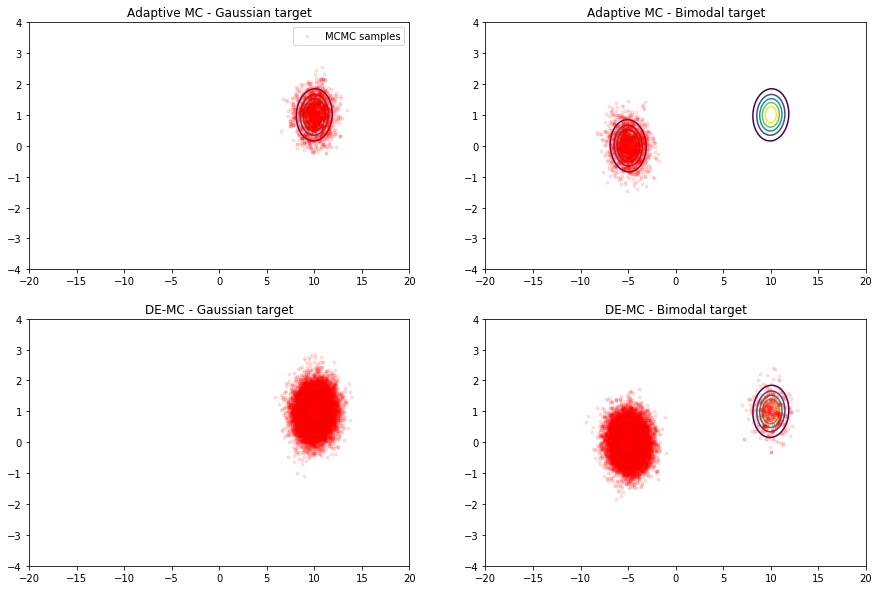

In [2]:
from scipy.stats import multivariate_normal, uniform
from functools import partial
means = [np.array([10, 1]), np.array([-5, 0])]
covs = [np.array([[1, 0.02], [0.02, 0.2]]), np.array([[1, -0.02], [-0.02, 0.2]])]
prior_sample = lambda nsamples: np.array([[-20, -4]]) + np.array([[40, 8]]) * lhs(n=2, samples=nsamples)
log_pdf_gauss = partial(multivariate_normal.logpdf, mean=means[0], cov=covs[0])
def log_pdf_bimodal(x):
    return np.log(2/6*multivariate_normal.pdf(x, mean=means[0], cov=covs[0]) + \
                  4/6*multivariate_normal.pdf(x, mean=means[1], cov=covs[1]))
log_pdfs = [log_pdf_gauss, log_pdf_bimodal]

fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=2)
titles_1 = ['Adaptive MC - ', 'DE-MC - ']
titles_2 = ['Gaussian target', 'Bimodal target']
for i in [0, 1]:
    for j, log_pdf_ in enumerate(log_pdfs):
        if i == 0:
            seed = prior_sample(nsamples=1)
            samples, _, _ = am(log_pdf=log_pdf_, seed=seed, T=10000, verbose=True)
        if i == 1:
            seed = prior_sample(nsamples=10)
            samples, _, _ = de_mc(log_pdf=log_pdf_, seed=seed, T=10000, verbose=True)
            _ = diagnostics_several_chains(samples)
        samples = post_process_samples(samples, burnin=500, jump=5, concatenate_chains=True)
        ax[i][j].plot(samples[:,0], samples[:,1], color='red', linestyle='none', marker='.', alpha=0.1, 
                      label='MCMC samples')
        x, y = np.mgrid[-20:20:.05, -4:4:.01]
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x; pos[:, :, 1] = y
        for m, c in zip(means[:j+1], covs[:j+1]):
            rv = multivariate_normal(m, c)
            ax[i][j].contour(x, y, rv.pdf(pos), 5, label='true pdf')
            ax[i][j].set_xlim([-20, 20]); ax[i][j].set_ylim([-4, 4])
        ax[i][j].set_title(titles_1[i]+titles_2[j])
ax[0][0].legend()
plt.show(fig)

In [3]:
all_inds = np.random.choice(3, replace=False, size=3)
print(all_inds)

[1 0 2]


In [4]:
Y = np.array([[10, 20], [2, 3], [5, 6]])
R = np.array([[1, 0.2], [0.2, 0.6]])
result = 0
for y in Y:
    result += np.matmul(np.matmul(y.reshape((1, 2)), np.linalg.inv(R)), y.reshape((2, 1)))
print(result)

[[764.28571429]]


In [5]:
import keras.backend as K

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def homoscedastic_loss_full_covariance(Y, inv_cov_n):
    # var_n is a fixed known full covariance, inv_cov_n is the inverse of the covariance matrix
    #Y = y_true-y_pred
    A = K.dot(Y, inv_cov_n)
    return K.sum(K.batch_dot(A, Y, axes=(1,1)))

Y2 = K.constant(Y)
print(Y.shape)
Rinv = K.constant(np.linalg.inv(R), dtype='float32')
print(K.eval(homoscedastic_loss_full_covariance(Y2, Rinv)))

(3, 2)
764.28564


In [7]:
a = 2.
print(len(a))

TypeError: object of type 'float' has no len()